In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imsave
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)


def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""

    input_layer = tf.reshape(features["x"],[-1,32,32,1])

    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

 
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])


    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

 
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      "classes": tf.argmax(input=logits, axis=1),

      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



In [2]:

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [17]:
xs = []
ys = []
d = unpickle('./cifar-10-batches-py/data_batch_1')
xs.append(d[b'data'])
ys.append(d[b'labels'])

d = unpickle('./cifar-10-batches-py/test_batch')
xtest=(d[b'data'])
ytest=(d[b'labels'])
xtest=xtest[:100,]
ytest=ytest[:100]
xs.append(xtest)
ys.append(ytest)

x = np.concatenate(xs)
y = np.concatenate(ys)
x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))

How does the training data look like?
2622th Training Data Label is 0


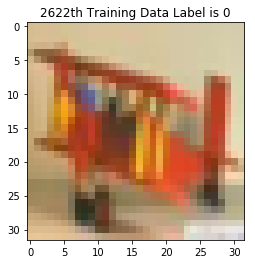

In [18]:
print ("How does the training data look like?")
nsample = 1
randidx = np.random.randint(x.shape[0], size=nsample)

for i in randidx:
    curr_img   = np.reshape(x[i, :], (32, 32,3)) # 28 by 28 matrix 
    curr_label = y[i] # Label
    plt.imshow(curr_img,cmap=plt.get_cmap('autumn'))
    plt.title("" + str(i) + "th Training Data " 
              + "Label is " + str(curr_label))
    print ("" + str(i) + "th Training Data " 
           + "Label is " + str(curr_label))
    plt.show()

In [19]:

x=x[:,:,0]*0.3+x[:,:,1]*0.59+x[:,:,2]*0.11  

How does the training data look like?
2669th Training Data Label is 7


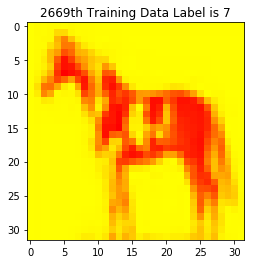

In [20]:
print ("How does the training data look like?")
nsample = 1
randidx = np.random.randint(x.shape[0], size=nsample)

for i in randidx:
    curr_img   = np.reshape(x[i, :], (32, 32)) # 28 by 28 matrix 
    curr_label = y[i] # Label
    plt.imshow(curr_img,cmap=plt.get_cmap('autumn'))
    plt.title("" + str(i) + "th Training Data " 
              + "Label is " + str(curr_label))
    print ("" + str(i) + "th Training Data " 
           + "Label is " + str(curr_label))
    plt.show()

In [21]:
def main(unused_argv):
  # Load training and eval data

    train_data=x[:10000,:]/255
    train_data=train_data.astype(np.float32)
    train_labels=y[:10000]
    train_labels.dtype='int'
    eval_data=x[:100,:]/255
    eval_data=eval_data.astype(np.float32)
    eval_labels=y[:100]
    eval_labels.dtype='int'
    
    
  # Create the Estimator
    mnist_classifier = tf.estimator.Estimator(
        model_fn=cnn_model_fn)

  # Set up logging for predictions
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(
        tensors=tensors_to_log, every_n_iter=50)

  # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
    mnist_classifier.train(
      input_fn=train_input_fn,
      steps=10000,
      hooks=[logging_hook])

  # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)


In [22]:
if __name__ == "__main__":
        tf.app.run()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/_6/ndd31jv50qsfqbr3_7g7k3g40000gn/T/tmpx9957djy', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/_6/ndd31jv50qsfqbr3_7g7k3g40000gn/T/tmpx9957djy/model.ckpt.
INFO:tensorflow:loss = 2.3162, step = 1
INFO:tensorflow:probabilities = [[ 0.09429121  0.11009863  0.09011973  0.10323256  0.10930231  0.0943052
   0.09424382  0.11365283  0.09257016  0.09818359]
 [ 0.08044799  0.12331703  0.07676096  0.11781993  0.12478544  0.09948076
   0.10194197  0.08615601  0.09375339  0.09553651]
 [ 0.09177602  0.10667382  0.09140217  0.10273287  0.12425968  0.09433163
   0.09317568  0.09055858  0.09702608  0.10806348]
 [ 0.08943221  0.10311628  0.09540212

INFO:tensorflow:probabilities = [[ 0.08759748  0.11081108  0.08550324  0.11223603  0.10156354  0.09598161
   0.09354559  0.10084445  0.10488664  0.10703039]
 [ 0.0736584   0.09838042  0.09321463  0.10508774  0.14244676  0.09648331
   0.08637209  0.08574208  0.11465872  0.10395586]
 [ 0.08945096  0.11189756  0.0880831   0.09448269  0.12148469  0.12133899
   0.09506331  0.07985455  0.10255814  0.09578611]
 [ 0.10102178  0.10392169  0.10175947  0.09791538  0.10987055  0.09068481
   0.09872144  0.10220295  0.08932867  0.10457331]
 [ 0.0859823   0.1013121   0.11313504  0.1148956   0.10650706  0.10357317
   0.09912094  0.08254529  0.08518945  0.10773905]
 [ 0.09850696  0.11043667  0.09535643  0.07631856  0.1284491   0.09233022
   0.08405591  0.11154645  0.08802985  0.11496978]
 [ 0.08864832  0.1074366   0.08113699  0.10927098  0.10866389  0.0813451
   0.1017921   0.11880144  0.09899782  0.10390679]
 [ 0.08988584  0.10195684  0.08949122  0.09205668  0.10501707  0.10335674
   0.11201268  0.092

INFO:tensorflow:global_step/sec: 2.06194
INFO:tensorflow:loss = 2.30546, step = 101 (48.499 sec)
INFO:tensorflow:probabilities = [[ 0.10478222  0.10955366  0.09070027  0.09523723  0.09666671  0.10083446
   0.1017779   0.10293258  0.09541845  0.10209651]
 [ 0.0868682   0.11181597  0.0897963   0.1011619   0.10506988  0.08966377
   0.10435905  0.1115465   0.08940431  0.11031417]
 [ 0.11506369  0.08709404  0.10037356  0.09299137  0.09979063  0.09101102
   0.09399814  0.09341456  0.10474933  0.12151356]
 [ 0.08931503  0.1067507   0.10705582  0.09752298  0.1016551   0.09841643
   0.10435855  0.09352008  0.10553461  0.09587078]
 [ 0.10413351  0.10678025  0.09612603  0.09458812  0.10437582  0.0970638
   0.09629671  0.1026509   0.08766889  0.11031594]
 [ 0.08627642  0.11414     0.10142056  0.10166753  0.11236353  0.09016945
   0.10019203  0.09644861  0.08901017  0.10831175]
 [ 0.09105825  0.10663535  0.0980588   0.10591277  0.11012588  0.09941512
   0.09742049  0.09553158  0.09810483  0.0977369

INFO:tensorflow:probabilities = [[ 0.10975314  0.09392351  0.10391408  0.09740203  0.10850888  0.09952489
   0.10368516  0.08434689  0.09490237  0.10403907]
 [ 0.07020564  0.10027584  0.09356339  0.09900765  0.10790115  0.09244623
   0.10973173  0.11101598  0.09073232  0.12512009]
 [ 0.09728733  0.09894074  0.10803721  0.09161498  0.09509115  0.09835353
   0.09670371  0.09590252  0.10618087  0.11188789]
 [ 0.0909046   0.12237168  0.09480015  0.10682642  0.09769545  0.08621585
   0.10137318  0.08561773  0.10434911  0.10984587]
 [ 0.09231608  0.09923833  0.09272566  0.10706843  0.1026111   0.09318174
   0.10095706  0.10329403  0.1029489   0.10565875]
 [ 0.07587684  0.10206006  0.09383474  0.10698144  0.09678685  0.08423925
   0.09159254  0.11017396  0.12110634  0.11734797]
 [ 0.08515081  0.10590804  0.10109817  0.09825644  0.11933725  0.09322406
   0.10305818  0.09636717  0.10801034  0.08958954]
 [ 0.08812705  0.10371679  0.0913092   0.11004746  0.10017963  0.10359787
   0.08276488  0.09

INFO:tensorflow:global_step/sec: 2.19712
INFO:tensorflow:loss = 2.29949, step = 201 (45.514 sec)
INFO:tensorflow:probabilities = [[ 0.09344404  0.1092672   0.09045194  0.10547621  0.11128227  0.08501485
   0.08965715  0.10629714  0.10394968  0.10515953]
 [ 0.10552288  0.11034784  0.09001619  0.09957907  0.1059541   0.09586348
   0.10249751  0.0933169   0.10039917  0.09650283]
 [ 0.09358726  0.1122131   0.09019707  0.11003154  0.0918372   0.09803916
   0.10918577  0.09754409  0.09802028  0.09934457]
 [ 0.10550279  0.10082478  0.09764825  0.10335477  0.10161041  0.09539862
   0.08814689  0.10010465  0.09774365  0.10966522]
 [ 0.09840837  0.09710705  0.09694759  0.10679796  0.10224204  0.10938559
   0.09731272  0.0898003   0.10214384  0.09985448]
 [ 0.0921339   0.09101015  0.09956615  0.10137901  0.1038883   0.08813626
   0.09901155  0.12379663  0.09053937  0.11053872]
 [ 0.10353895  0.11491436  0.09803382  0.09569813  0.09032964  0.08466227
   0.09242727  0.11546683  0.09828088  0.106647

INFO:tensorflow:probabilities = [[ 0.13315307  0.10385621  0.09784504  0.08255085  0.08023146  0.07762805
   0.12351542  0.09848668  0.10006484  0.10266844]
 [ 0.09523376  0.09422168  0.10802711  0.103319    0.09254573  0.09397783
   0.11225665  0.10354097  0.09166355  0.10521373]
 [ 0.09051382  0.11246031  0.10258542  0.0957699   0.12744455  0.08666994
   0.0899014   0.09533512  0.09686071  0.10245875]
 [ 0.09061227  0.10355501  0.09574852  0.10651458  0.09736092  0.09543055
   0.10300028  0.11136225  0.09685737  0.09955818]
 [ 0.11292787  0.10427439  0.09706436  0.10228903  0.08376461  0.08949751
   0.09981048  0.10635069  0.09295608  0.111065  ]
 [ 0.10122692  0.09772616  0.10170886  0.10315385  0.1010473   0.09707627
   0.1032675   0.1014258   0.0965931   0.09677427]
 [ 0.11305038  0.09493732  0.09454107  0.11051308  0.11923895  0.09229105
   0.09362181  0.09746121  0.09505583  0.08928937]
 [ 0.08580118  0.10336766  0.10617021  0.11574339  0.10465267  0.0919593
   0.08547541  0.095

INFO:tensorflow:global_step/sec: 2.19686
INFO:tensorflow:loss = 2.30077, step = 301 (45.520 sec)
INFO:tensorflow:probabilities = [[ 0.09699318  0.08036259  0.11545096  0.10600431  0.10161947  0.09724666
   0.09831498  0.10652614  0.10021944  0.09726233]
 [ 0.09006104  0.11801105  0.08848881  0.09937149  0.12439155  0.09024147
   0.07796738  0.09361412  0.11230922  0.10554378]
 [ 0.10971239  0.09429015  0.09935724  0.09587419  0.10467549  0.09340793
   0.09608449  0.10600027  0.10334005  0.09725782]
 [ 0.09792631  0.099434    0.1001117   0.08547454  0.09758197  0.10215277
   0.07810413  0.09995466  0.11656939  0.12269055]
 [ 0.10373254  0.10058316  0.10308231  0.10140837  0.1046003   0.09362106
   0.09069555  0.10369575  0.09013063  0.1084504 ]
 [ 0.10490734  0.09952617  0.09418559  0.09533282  0.10406969  0.10050322
   0.08597877  0.10817959  0.10216298  0.1051538 ]
 [ 0.0899891   0.10466547  0.09904033  0.10214729  0.11867535  0.09276754
   0.08890667  0.1012613   0.10933494  0.093212

INFO:tensorflow:probabilities = [[ 0.09161607  0.09397086  0.09164817  0.09446324  0.11178495  0.12260447
   0.10424916  0.08742113  0.10560426  0.09663761]
 [ 0.10529935  0.11915488  0.08850097  0.08286569  0.08652434  0.0940585
   0.09793921  0.09174081  0.12208098  0.11183529]
 [ 0.1097071   0.09205423  0.09466619  0.10030211  0.10257384  0.10203002
   0.10012142  0.0798379   0.0990697   0.11963744]
 [ 0.10562406  0.09868688  0.09103961  0.11481302  0.10392127  0.10165661
   0.10222723  0.09464991  0.10260853  0.08477286]
 [ 0.09682655  0.09334528  0.0909038   0.11116692  0.09572624  0.08247066
   0.10852291  0.09853849  0.1011124   0.12138674]
 [ 0.1055662   0.1087797   0.07539446  0.1386057   0.10539119  0.0856028
   0.10396314  0.08872513  0.08544893  0.10252269]
 [ 0.1146378   0.08210295  0.10126252  0.1042297   0.09518177  0.11554777
   0.08556355  0.09621156  0.09502193  0.11024044]
 [ 0.08517267  0.09725361  0.09942376  0.12294379  0.10200032  0.10074064
   0.09956014  0.1107

INFO:tensorflow:global_step/sec: 2.22339
INFO:tensorflow:loss = 2.28681, step = 401 (44.976 sec)
INFO:tensorflow:probabilities = [[ 0.10914204  0.09503316  0.09800628  0.10730043  0.10645322  0.08602759
   0.1018823   0.1053751   0.09275604  0.09802389]
 [ 0.10272378  0.11441076  0.09078738  0.10181385  0.1025872   0.09704092
   0.09311529  0.0907816   0.1021402   0.10459894]
 [ 0.08641332  0.1037895   0.0909611   0.09119516  0.11335796  0.08780203
   0.09806181  0.1012419   0.10766971  0.11950747]
 [ 0.11073585  0.09274708  0.10802363  0.10893178  0.09986219  0.11055269
   0.09082136  0.10923465  0.07945991  0.08963086]
 [ 0.09834106  0.1066888   0.09643763  0.10121316  0.09775461  0.09769118
   0.10162693  0.10084537  0.10412528  0.09527599]
 [ 0.09298711  0.0966031   0.08924913  0.11391183  0.11400308  0.09680628
   0.08897699  0.09806484  0.10150173  0.10789596]
 [ 0.09785296  0.11427356  0.08816673  0.11169825  0.09518944  0.08900192
   0.09511362  0.094526    0.10095346  0.113224

INFO:tensorflow:probabilities = [[ 0.12229475  0.1090257   0.09121555  0.10556268  0.09510085  0.0858634
   0.11364847  0.08998046  0.08855347  0.09875466]
 [ 0.09718826  0.09832304  0.1091999   0.1064937   0.09158721  0.09503868
   0.08584648  0.10328197  0.11122206  0.10181874]
 [ 0.09794607  0.10051093  0.10342026  0.10776908  0.09739532  0.0963622
   0.09870491  0.10319763  0.10390265  0.09079096]
 [ 0.10857652  0.10538357  0.09556368  0.1144952   0.10957783  0.08539675
   0.08431059  0.10560377  0.09376577  0.09732626]
 [ 0.10054559  0.10587884  0.093796    0.11334724  0.09523219  0.09706814
   0.08327713  0.09603661  0.10877508  0.10604322]
 [ 0.11786824  0.09975214  0.09645845  0.11812483  0.0931287   0.08387642
   0.0940069   0.10922634  0.09875458  0.0888034 ]
 [ 0.0928587   0.10359292  0.11766538  0.08326618  0.08858145  0.08419512
   0.10694686  0.09742358  0.10013775  0.12533207]
 [ 0.09765121  0.1070562   0.09910411  0.10097147  0.09460654  0.09042694
   0.09758055  0.1104

INFO:tensorflow:global_step/sec: 2.19639
INFO:tensorflow:loss = 2.28738, step = 501 (45.530 sec)
INFO:tensorflow:probabilities = [[ 0.09833116  0.08854115  0.10199521  0.10314776  0.09993825  0.09894724
   0.0955156   0.10146029  0.10640125  0.10572213]
 [ 0.10573919  0.10098531  0.09014758  0.09728049  0.09165967  0.09494747
   0.1145673   0.09277648  0.10031538  0.11158106]
 [ 0.12239251  0.11064377  0.07809833  0.08641037  0.08666003  0.10038271
   0.09923767  0.1057015   0.09094244  0.11953072]
 [ 0.10121782  0.09402089  0.09798703  0.08913729  0.10414706  0.09206329
   0.09955567  0.10984731  0.10961466  0.10240903]
 [ 0.09047268  0.11239282  0.07432534  0.0934514   0.10595988  0.09663653
   0.0947701   0.11430652  0.09797837  0.11970629]
 [ 0.10720406  0.10465644  0.09623276  0.09097741  0.08539178  0.08751263
   0.10043306  0.09699324  0.11612899  0.11446968]
 [ 0.11242507  0.10046174  0.11087589  0.09534751  0.10918921  0.09502356
   0.09025867  0.09586133  0.09126791  0.099289

INFO:tensorflow:probabilities = [[ 0.10715983  0.11242393  0.09401425  0.10802366  0.09321167  0.09081325
   0.09146734  0.0984822   0.10623619  0.0981677 ]
 [ 0.11448909  0.10422754  0.08427296  0.09321254  0.09951185  0.10735308
   0.11536807  0.09258363  0.09176134  0.09721989]
 [ 0.09180226  0.09841609  0.11086866  0.09689704  0.10090808  0.10491589
   0.11100144  0.09170233  0.10053854  0.0929497 ]
 [ 0.1041254   0.10282494  0.09004209  0.08753092  0.10104048  0.10433729
   0.0884827   0.09523088  0.10775229  0.11863302]
 [ 0.09883998  0.1096167   0.09461273  0.09867174  0.1029696   0.09192636
   0.10297672  0.1047297   0.09772959  0.0979269 ]
 [ 0.10060348  0.10243215  0.10242178  0.11102165  0.08498665  0.10009668
   0.09560513  0.09011466  0.10895466  0.10376311]
 [ 0.09221742  0.11056425  0.10648836  0.09896887  0.09931311  0.07968269
   0.08605448  0.09454261  0.12651439  0.10565383]
 [ 0.12605739  0.0873049   0.10623218  0.09559441  0.07772239  0.07748074
   0.10871658  0.10

INFO:tensorflow:global_step/sec: 2.20544
INFO:tensorflow:loss = 2.29513, step = 601 (45.342 sec)
INFO:tensorflow:probabilities = [[ 0.1195526   0.09265211  0.11305253  0.08370323  0.09468073  0.09301282
   0.10253221  0.10485642  0.10340083  0.09255654]
 [ 0.11668052  0.10532159  0.10448574  0.1171592   0.08854689  0.08489299
   0.0912995   0.09946859  0.0947613   0.0973836 ]
 [ 0.10149073  0.09381377  0.1035606   0.10000969  0.08434404  0.08876285
   0.11717342  0.11186745  0.10432979  0.09464759]
 [ 0.10262662  0.10118618  0.11546459  0.11543015  0.08983864  0.09587175
   0.08993641  0.099818    0.09490153  0.09492606]
 [ 0.11784119  0.08841117  0.10978059  0.11586382  0.09099958  0.10834716
   0.09073577  0.08638077  0.09862382  0.09301613]
 [ 0.09999929  0.09931676  0.09144995  0.11076856  0.10260713  0.09670121
   0.09482655  0.09742031  0.09685212  0.11005802]
 [ 0.10301056  0.09627015  0.10436991  0.09689388  0.10459702  0.09870338
   0.11409883  0.09161101  0.09762932  0.092815

INFO:tensorflow:probabilities = [[ 0.09861314  0.10545379  0.11435854  0.09361927  0.07373461  0.08224429
   0.07996853  0.10007541  0.13258673  0.11934569]
 [ 0.1059854   0.10716846  0.09903071  0.0906786   0.09796095  0.09526893
   0.09027969  0.09690326  0.10713635  0.10958771]
 [ 0.08268958  0.09019385  0.09854396  0.10258114  0.10162429  0.09040108
   0.11449364  0.10338864  0.10921723  0.10686666]
 [ 0.10168692  0.10433505  0.10085047  0.0945308   0.09669384  0.08880446
   0.09605796  0.10866991  0.10621466  0.10215597]
 [ 0.10903126  0.11717875  0.08377872  0.09724654  0.08009008  0.0956523
   0.10182423  0.11123366  0.10268799  0.10127646]
 [ 0.10639936  0.11342942  0.09018905  0.10568418  0.11944952  0.07526655
   0.09638514  0.10816312  0.08499873  0.10003491]
 [ 0.12162758  0.0938262   0.08938085  0.08434591  0.10293423  0.10112454
   0.09596985  0.09315909  0.10232572  0.11530593]
 [ 0.10445535  0.113386    0.10933268  0.09675686  0.09958381  0.09042253
   0.09214982  0.095

INFO:tensorflow:global_step/sec: 2.17755
INFO:tensorflow:loss = 2.29462, step = 701 (45.923 sec)
INFO:tensorflow:probabilities = [[ 0.10692365  0.09575871  0.09661605  0.09870432  0.10307138  0.09136222
   0.09139182  0.09511325  0.11503149  0.10602712]
 [ 0.100851    0.11812507  0.08705578  0.08672971  0.08319288  0.08926472
   0.09854876  0.09763194  0.10187417  0.13672599]
 [ 0.09781661  0.09869262  0.09387579  0.11166896  0.09976713  0.10218705
   0.10763933  0.09878252  0.09778425  0.09178572]
 [ 0.11236011  0.10498888  0.08090133  0.0872019   0.08009376  0.08154891
   0.09763344  0.11444321  0.10025305  0.14057544]
 [ 0.09435043  0.10288314  0.08519691  0.09513382  0.07789861  0.08954032
   0.10580631  0.09185797  0.12714574  0.13018678]
 [ 0.10190842  0.09650713  0.0888713   0.11326762  0.09566925  0.09511282
   0.10238973  0.09880399  0.10632148  0.10114825]
 [ 0.10299902  0.09875892  0.09364065  0.09642494  0.10467006  0.10192836
   0.09471796  0.09775367  0.10804605  0.101060

KeyboardInterrupt: 